# Final ML project: Bankruptcy prediction

# Objectives

Here we will look at various Phases of Machine Learning Model development, especially
- Data cleaning and Analysis
- Feature Engineering
- Creating, testing and evaluating models
- Error analysis
- Accuracy Prediction


In [163]:
import pandas as pd
import numpy as np
from scipy import stats
import os
import mglearn

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 7

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.impute import SimpleImputer

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile

from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras import layers
#from tensorflow.python.keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# The data

- directory for training: `./Bankruptcy/train`

The data directory will contain one file per year.
- There are 5 years refered to as 1 through 5
- Files named: `1st_yr.csv,  2nd_yr.csv,  3rd_yr.csv,  4th_yr.csv,  5th_yr.csv`
- Let $i \in \{1, 2, 3, 4, 5 \}$.  The data in the file for year $-i$ contains
    - contains company characteristics for year $i$
    - the Bankruptcy field indicates whether the company is Bankrupt/Not Bankrupt in **year 6**
        - for year 1 (`1st.csv`), whether the company survives for 5 more years to **year 6**
        - for year 2 (`2nd.csv`), whether the company survives for 4 more years to **year 6**
        - and so forth

        
We will need to 
- decide which files and which fields to use
- prepare the data for training and testing


In [164]:
TRAIN_PATH = "./Bankruptcy/train"
TEST_PATH = "./Bankruptcy/sample"

In [165]:
%pfile ./Bankruptcy/train/1st_yr.csv

Object `./Bankruptcy/train/1st_yr.csv` not found.


In [166]:
%%bash
head -2 ./Bankruptcy/train/1st_yr.csv

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0.037155,0.75222,-0.0352,0.93331,-69.845,0.037155,0.050562,0.3294,1.0353,0.24778,0.050562,0.095792,0.037793,0.050562,3193.3,0.1143,1.3294,0.050562,0.022225,61.397,?,0.070229,0.016332,0.050562,0.24778,0.096479,0.31959,-0.069378,4.0898,0.33041,0.022225,87.673,4.1632,0.093363,0.070229,2.2801,0.48998,0.47217,0.030869999999999998,0.004017,0.23409,0.030869999999999998,78.697,17.3,0.097093,0.2083,63.564,0.034812,0.015302000000000001,0.6549,0.52783,0.2402,0.48836,0.93062,-432.84,0.034079000000000005,0.14995,0.9659200000000001,0.9056,5.9449,21.098,84.685,4.3101,4.4838,0,3735


#Using SimpleImputer in Scikit-Learn,
replace the missing values (NaN) with the median values in the data

In [167]:
# all data files from each path stored in each dictionary
def data_reading(PATH):
    data_files = {}
    #loop through all files in directory
    for file_name in os.listdir(PATH):
        print("Reading file: ", file_name)
        
        data_table = pd.read_csv(os.path.join(PATH, file_name), index_col=['Id'], low_memory=False)
        data_table.replace('?', np.nan, inplace = True)
        data_table.iloc[:, :-1] = data_table.iloc[:, :-1].astype(np.float64)
        
        # fill missing value with median
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
        data_table.loc[:, data_table.columns!='Bankrupt'] = imp_mean.fit_transform(data_table.loc[:, data_table.columns!='Bankrupt'])
        
        # save
        data_files[file_name[:-4]] = data_table
    
    print("Finished Reading for Folder: ", PATH)
    return data_files

In [168]:
train_files = data_reading(TRAIN_PATH)
test_files = data_reading(TEST_PATH)

Reading file:  1st_yr.csv
Reading file:  2nd_yr.csv
Reading file:  3rd_yr.csv
Reading file:  4th_yr.csv
Reading file:  5th_yr.csv
Finished Reading for Folder:  ./Bankruptcy/train
Reading file:  1st_yr.csv
Reading file:  2nd_yr.csv
Reading file:  3rd_yr.csv
Reading file:  4th_yr.csv
Reading file:  5th_yr.csv
Finished Reading for Folder:  ./Bankruptcy/sample


### Attribute Information:
  
Id Company Identifier  
X1 net profit / total assets  
X2 total liabilities / total assets  
X3 working capital / total assets  
X4 current assets / short-term liabilities  
X5 [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365  
X6 retained earnings / total assets  
X7 EBIT / total assets  
X8 book value of equity / total liabilities  
X9 sales / total assets  
X10 equity / total assets  
X11 (gross profit + extraordinary items + financial expenses) / total assets  
X12 gross profit / short-term liabilities  
X13 (gross profit + depreciation) / sales  
X14 (gross profit + interest) / total assets  
X15 (total liabilities * 365) / (gross profit + depreciation)  
X16 (gross profit + depreciation) / total liabilities  
X17 total assets / total liabilities  
X18 gross profit / total assets  
X19 gross profit / sales  
X20 (inventory * 365) / sales  
X21 sales (n) / sales (n-1)  
X22 profit on operating activities / total assets  
X23 net profit / sales  
X24 gross profit (in 3 years) / total assets  
X25 (equity - share capital) / total assets  
X26 (net profit + depreciation) / total liabilities  
X27 profit on operating activities / financial expenses  
X28 working capital / fixed assets  
X29 logarithm of total assets  
X30 (total liabilities - cash) / sales  
X31 (gross profit + interest) / sales  
X32 (current liabilities * 365) / cost of products sold  
X33 operating expenses / short-term liabilities  
X34 operating expenses / total liabilities  
X35 profit on sales / total assets  
X36 total sales / total assets  
X37 (current assets - inventories) / long-term liabilities  
X38 constant capital / total assets  
X39 profit on sales / sales  
X40 (current assets - inventory - receivables) / short-term liabilities  
X41 total liabilities / ((profit on operating activities + depreciation) * (12/365))  
X42 profit on operating activities / sales  
X43 rotation receivables + inventory turnover in days  
X44 (receivables * 365) / sales  
X45 net profit / inventory  
X46 (current assets - inventory) / short-term liabilities  
X47 (inventory * 365) / cost of products sold  
X48 EBITDA (profit on operating activities - depreciation) / total assets  
X49 EBITDA (profit on operating activities - depreciation) / sales  
X50 current assets / total liabilities  
X51 short-term liabilities / total assets  
X52 (short-term liabilities * 365) / cost of products sold)  
X53 equity / fixed assets  
X54 constant capital / fixed assets  
X55 working capital  
X56 (sales - cost of products sold) / sales  
X57 (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)  
X58 total costs /total sales  
X59 long-term liabilities / equity  
X60 sales / inventory  
X61 sales / receivables  
X62 (short-term liabilities *365) / sales  
X63 sales / short-term liabilities  
X64 sales / fixed assets  


In [169]:
train_files['1st_yr'].describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
count,5744.000000,5744.000000,5744.000000,5744.000000,5.744000e+03,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,...,5.744000e+03,5744.000000,5.744000e+03,5744.000000,5.744000e+03,5744.000000,5.744000e+03,5744.000000,5744.000000,5744.000000
mean,0.019249,0.572996,0.104619,2.649544,-1.901397e+02,0.056435,0.333718,2.657701,5.709752,1.925513,...,-1.928692e+02,0.245292,1.938742e+02,0.234913,4.998401e+02,16.823723,4.539629e+03,8.238839,229.910772,0.035515
std,5.047982,5.914677,5.832130,14.163582,4.011208e+04,6.690639,9.100296,20.283874,101.076954,34.562625,...,1.462346e+04,2.379982,1.462345e+04,6.924780,2.861504e+04,288.767419,3.300802e+05,20.636441,5564.368199,0.185094
min,-256.890000,-72.162000,-440.500000,0.000000,-2.722100e+06,-397.890000,-189.560000,-141.410000,0.000005,-440.550000,...,-1.108300e+06,-47.491000,-1.436000e-03,-327.970000,4.700000e-05,0.000016,0.000000e+00,0.000015,0.000010,0.000000
25%,0.020799,0.298790,0.027175,1.065950,-4.430525e+01,0.000000,0.026850,0.451745,1.037275,0.302478,...,1.961300e-02,0.055897,8.647975e-01,0.000000,6.016375e+00,4.829375,4.327875e+01,3.410525,2.525650,0.000000
50%,0.076136,0.481790,0.181155,1.501750,-5.309400e+00,0.000000,0.090299,1.021400,1.207000,0.495330,...,6.286150e-02,0.176390,9.394150e-01,0.030083,1.002300e+01,7.010400,6.841500e+01,5.313050,4.643200,0.000000
75%,0.160530,0.676865,0.360538,2.431425,3.799475e+01,0.145385,0.189370,2.233400,2.136325,0.673507,...,1.375500e-01,0.352950,9.822225e-01,0.271298,1.969125e+01,10.660000,1.070250e+02,8.310750,9.802950,0.000000
max,94.280000,441.500000,1.000000,1017.800000,9.909000e+05,303.670000,453.770000,1452.200000,3876.100000,1099.500000,...,1.000000e+00,126.670000,1.108300e+06,119.580000,2.137800e+06,21110.000000,2.501600e+07,1042.200000,294770.000000,1.000000


In [170]:
test_files['1st_yr'].describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
count,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,...,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000
mean,-0.002618,1.144837,-0.583621,2.510333,-157.781381,-0.640353,1.188808,2.326794,10.565021,2.445654,...,6005.859105,0.076032,0.328639,0.924501,0.292637,67.367182,15.743652,348.953047,8.082970,252.076016
std,2.580712,18.662709,18.396434,4.166738,7256.982753,16.612002,20.911205,5.253714,160.531860,52.017683,...,39843.941148,0.619234,3.201322,0.617630,1.691793,734.710149,123.338404,5268.867844,11.245905,3017.120025
min,-61.602000,-72.162000,-440.500000,0.002265,-163090.000000,-397.890000,-61.602000,-15.236000,0.065762,-440.550000,...,-589300.000000,-14.206000,-19.425000,0.000000,-15.102000,0.485190,0.046917,0.000000,0.002944,0.002567
25%,0.016020,0.296893,0.018023,1.039825,-43.323000,0.000000,0.020880,0.449510,1.038450,0.302430,...,31.260000,0.016775,0.044971,0.860873,0.000000,5.885175,5.101675,42.211500,3.529550,2.499750
50%,0.072736,0.491430,0.175770,1.486900,-9.886150,0.000000,0.085098,1.018900,1.230950,0.498105,...,1585.500000,0.064045,0.169720,0.936760,0.018124,10.137000,7.353950,67.634000,5.348600,4.541700
75%,0.152845,0.681800,0.368300,2.604100,35.698000,0.123865,0.186455,2.250800,2.295850,0.677627,...,5742.675000,0.138265,0.349832,0.983088,0.249770,20.082000,10.980250,103.410000,8.563975,9.824975
max,1.138800,441.500000,0.894910,55.877000,55089.000000,1.800200,453.770000,74.455000,3668.300000,1099.500000,...,511290.000000,1.000000,71.053000,15.206000,25.510000,17154.000000,2939.400000,123970.000000,172.020000,44785.000000


(array([5540.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         204.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

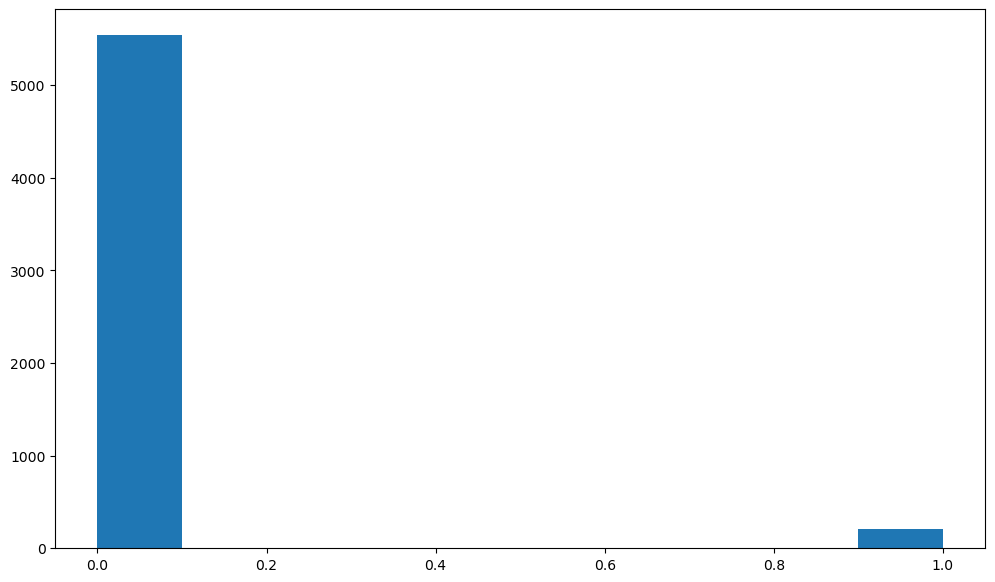

In [171]:
plt.hist(train_files['1st_yr'].iloc[:,-1])
#train_files['1st_yr'].iloc[:,-1]

In [172]:
test_files['1st_yr'].shape

(574, 64)

In [173]:
train_files['1st_yr'].shape

(5744, 65)

In [174]:
train_data = pd.concat(train_files, axis=1, join='inner')

In [175]:
train_data.loc[:, (slice(None), 'Bankrupt')].head()

,1st_yr,2nd_yr,3rd_yr,4th_yr,5th_yr
,Bankrupt,Bankrupt,Bankrupt,Bankrupt,Bankrupt
Id,,,,,
3735,0,0,0,0,0
4564,1,0,0,0,0
5877,0,0,0,1,0
2507,0,0,0,0,0
3901,0,0,0,0,0


In [176]:
np.isnan(train_data)

1st_yr                                                                 \
         X1     X2     X3     X4     X5     X6     X7     X8     X9    X10   
Id                                                                           
3735  False  False  False  False  False  False  False  False  False  False   
4564  False  False  False  False  False  False  False  False  False  False   
5877  False  False  False  False  False  False  False  False  False  False   
2507  False  False  False  False  False  False  False  False  False  False   
3901  False  False  False  False  False  False  False  False  False  False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
5611  False  False  False  False  False  False  False  False  False  False   
5456  False  False  False  False  False  False  False  False  False  False   
2579  False  False  False  False  False  False  False  False  False  False   
1970  False  False  False  False  False  False  False  False  False  False   
5663  False  False  False  False  False  False  False  False  False  False   

      ... 5th_yr                                                          \
      ...    X56    X57    X58    X59    X60    X61    X62    X63    X64   
Id    ...                                                                  
3735  ...  False  False  False  False  False  False  False  False  False   
4564  ...  False  False  False  False  False  False  False  False  False   
5877  ...  False  False  False  False  False  False  False  False  False   
2507  ...  False  False  False  False  False  False  False  False  False   
3901  ...  False  False  False  False  False  False  False  False  False   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
5611  ...  False  False  False  False  False  False  False  False  False   
5456  ...  False  False  False  False  False  False  False  False  False   
2579  ...  False  False  False  False  False  False  False  False  False   
1970  ...  False  False  False  False  False  False  False  False  False   
5663  ...  False  False  False  False  False  False  False  False  False   

               
     Bankrupt  
Id             
3735    False  
4564    False  
5877    False  
2507    False  
3901    False  
...       ...  
5611    False  
5456    False  
2579    False  
1970    False  
5663    False  

[3927 rows x 325 columns]

# Data Cleaning 

In [177]:
np.any(np.isnan(train_data))

False

# Data Reduction
Now, let us switch the gear and practice reducing the data. As we learn in the lecture, we can either reduce the dimensionality of data or reduce the number of data samples. Let us briefly taste them.

Here we practice subsampling to reduce the data. Subsampling is often useful to avoid computational overhead when it is properly used (without breaking original distribution of data).

In [178]:
def drop_numerical_outliers(df, z_thresh=3):
    print('Before dropping outliers: ', df.shape)
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.iloc[:,:-1].select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh).all(axis=1)
    # Drop (inplace) values set to be rejected
    df.drop(df.index[~constrains], inplace=True)
    print('After dropping outliers: ', df.shape)
    #axis=1, result_type='reduce'
    
## use variance threshhold here to reduce the dimension

In [179]:
from sklearn.model_selection import train_test_split
# split train and test 
def split_data(X, y):
    X_train, X_test, t_train, t_test = train_test_split(X, y,test_size=0.20, random_state=0)
    print("Train data shape: {}".format(X_train.shape))
    print("Train target shape: {}".format(t_train.shape))
    print("Test data shape: {}".format(X_test.shape))
    print("Test target shape: {}".format(t_test.shape))
    return X_train, X_test, t_train, t_test

In [180]:
#Use these Features for Feature selection and reduce dimension
from sklearn.feature_selection import VarianceThreshold
def reduce_dimension(data_X):
    vt = VarianceThreshold(threshold=(3))
    vt_X_train = vt.fit_transform(data_X)    
    print(vt.get_feature_names_out())
    featureList = vt.get_feature_names_out()
    reduced_data = data_X.drop(columns=[col for col in data_X if col not in featureList], axis=1)
    print('After dropping outliers: ', reduced_data.shape)
    return reduced_data

In [181]:
"""
Need to split train test sets before upsampling
We only upsample train set

Use different method to upsample -- TODO
"""
def upsampling_minority(X, y):
    # setting up testing and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
    
    print('Before upsampling: training data shape', X_train.shape, 'test data shape', X_test.shape)
    print("Unbalanced training data{}".format({n: v for n, v in zip(['Not Bankrupt', 'Bankrupt'], np.bincount(y_train))}))
    
    sm = SMOTE(random_state=10)
    X_train, y_train = sm.fit_resample(X_train, y_train)
   
    print('Finished upsampling: training data shape', X_train.shape, 'test data shape', X_test.shape)
    print("Balanced training data {}".format({n: v for n, v in zip(['Not Bankrupt', 'Bankrupt'], np.bincount(y_train))}))
    
    return X_train, X_test, y_train, y_test

In [182]:
def nn_3layers(n_hiddens=[64,16], input_size=64):
    nn_model = Sequential([ layers.Dense(n_hiddens[0], activation=tf.nn.relu, name="hidden1", input_shape=(input_size,)),
                               layers.Dense(n_hiddens[1], activation=tf.nn.relu, name='hidden2'),
                               layers.Dense(1, activation=tf.nn.sigmoid, name="outputs")
                             ]
                            )
    nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return nn_model

In [183]:
def nn_grid_search(X_train, y_train, X_test ,y_test,train_accs ,test_accs,score_method, nn_layers=nn_3layers):
    nn_model = KerasClassifier(build_fn=nn_layers)
    pipe_nn = make_pipeline(PolynomialFeatures(include_bias=False), StandardScaler(), nn_model)
    param_nn = [{'polynomialfeatures__degree': [1],
                'kerasclassifier__input_size': [len(PolynomialFeatures(1, include_bias=False).fit(X_train).get_feature_names())],
                'kerasclassifier__n_hiddens': [[64, 16], [32, 16]],
                'kerasclassifier__epochs': [5,10],
                'kerasclassifier__batch_size': [64, 128]
               },
                {'polynomialfeatures__degree': [2],
                'kerasclassifier__input_size': [len(PolynomialFeatures(2, include_bias=False).fit(X_train).get_feature_names())],
                'kerasclassifier__n_hiddens': [[64, 16], [32, 16]],
                'kerasclassifier__epochs': [5,10],
                'kerasclassifier__batch_size': [64, 128]
               }]
    nsearch = GridSearchCV(estimator=pipe_nn, 
                        param_grid=param_nn,
                        scoring=score_method,
                        n_jobs=-1,
                        cv=3)

    nsearch.fit(X_train, y_train)
    print('Best parameters: ', nsearch.best_params_)
    
    nn_model =  nsearch.best_estimator_
    
    t_test = nn_model.predict(X_test)
    
    cm_report  = classification_report(y_test, t_test)
    print(cm_report)
    
    train_score = nn_model.score(X_train, y_train)
        
    test_score = nn_model.score(X_test, y_test)

    print(f"Train Accuracy: {train_score}\nTest Accuracy: {test_score}")
    # Track each model/classifier's train and test accuracy
    
    train_accs.append(train_score)
    test_accs.append(test_score)

    return train_accs ,test_accs

        

# Model Execution

In [184]:
def MyModel(X_train, X_test, y_train, y_test):
    from sklearn.linear_model import SGDClassifier
    sgd = SGDClassifier(max_iter=1000, tol=1e-3)

    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression(random_state=0)

    from sklearn import neighbors
    knn = neighbors.KNeighborsClassifier() 

    from sklearn.naive_bayes import GaussianNB
    nb = GaussianNB()

    from sklearn import svm
    svm = svm.SVC()

    # list of algorithms to test
    clfs = [ sgd, logreg, knn, nb , svm]
    # list of algorithm names 
    names = ["SGD", "Logistic Reg", "kNN", "Naive Bayes","Support Vector Machine"]
    train_accs = []
    test_accs = []
   
    for name, clf in zip(names, clfs):
        print("{:=^50s}".format(name))

        # TODO 18.3
        clf.fit(X_train, y_train)


        train_score = clf.score(X_train, y_train)

        
        test_score = clf.score(X_test, y_test)

        print(f"Train Accuracy: {train_score}\nTest Accuracy: {test_score}")
        # Track each model/classifier's train and test accuracy
        train_accs.append(train_score)
        test_accs.append(test_score)
        
        t_train = clf.predict(X_train)

        
        t_test = clf.predict(X_test)
        
        mcc_score = matthews_corrcoef(y_test, t_test)
        print(f"MCC: {mcc_score}")
    
        
        #target_names = ['M', 'F', 'I']
        cm_report  = classification_report(y_test, t_test)
        print(cm_report)

        # TODO 9.8
        cm = confusion_matrix(y_test, t_test)
        cm_display = ConfusionMatrixDisplay(cm).plot()

        plt.figure(figsize=(12,4))

        plt.subplot(121)
        plt.plot(y_train, 'ro')
        plt.plot(t_train, 'bx')
        plt.title("Train")

        plt.subplot(122)
        plt.plot(y_test, 'ro')
        plt.plot(t_test, 'bx')
        plt.title("Test")
        plt.suptitle(name)
        plt.show()
    return train_accs, test_accs

In [185]:
data = train_files['1st_yr'].copy()  # can also try data for other years

In [186]:
"""
Sampling
"""
#drop_numerical_outliers(data)
red_data = reduce_dimension(data)
print("data shape : " ,data.shape)
#y = data.loc[:,'Bankrupt']
#X = data.loc[:, data.columns!='Bankrupt']
y = data.loc[:,'Bankrupt']
print(y.count())
X = red_data.loc[:, red_data.columns!='Bankrupt']
X_train, X_test, y_train, y_test = upsampling_minority(X, y)


['X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' 'X9' 'X10' 'X11' 'X12' 'X13'
 'X14' 'X15' 'X16' 'X17' 'X18' 'X19' 'X20' 'X21' 'X22' 'X23' 'X24' 'X25'
 'X26' 'X27' 'X28' 'X30' 'X31' 'X32' 'X33' 'X34' 'X35' 'X36' 'X37' 'X38'
 'X39' 'X40' 'X41' 'X42' 'X43' 'X44' 'X45' 'X46' 'X47' 'X48' 'X49' 'X50'
 'X51' 'X52' 'X53' 'X54' 'X55' 'X56' 'X57' 'X58' 'X59' 'X60' 'X61' 'X62'
 'X63' 'X64']
After dropping outliers:  (5744, 63)
data shape :  (5744, 65)
5744
Before upsampling: training data shape (4308, 63) test data shape (1436, 63)
Unbalanced training data{'Not Bankrupt': 4160, 'Bankrupt': 148}
Finished upsampling: training data shape (8320, 63) test data shape (1436, 63)
Balanced training data {'Not Bankrupt': 4160, 'Bankrupt': 4160}


# Feature Selection

=======================SGD========================
Train Accuracy: 0.5359375
Test Accuracy: 0.7736768802228412
MCC: -0.044957513655524584
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1380
           1       0.02      0.11      0.04        56

    accuracy                           0.77      1436
   macro avg       0.49      0.45      0.45      1436
weighted avg       0.92      0.77      0.84      1436



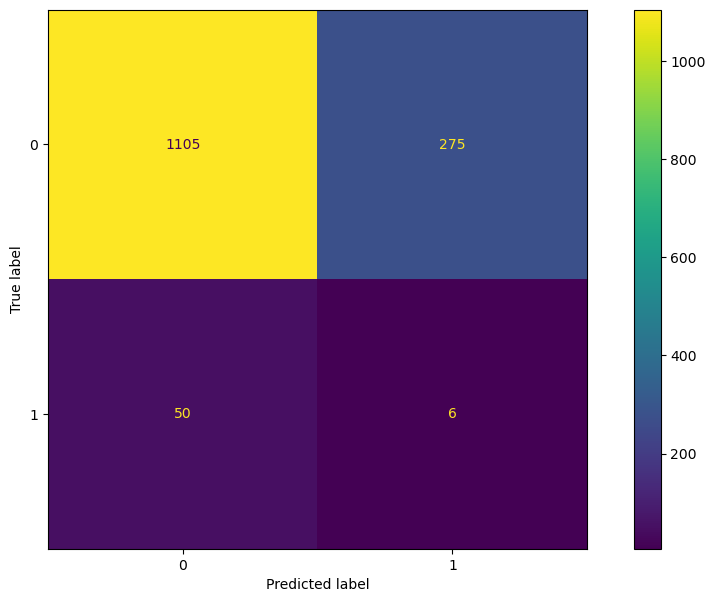

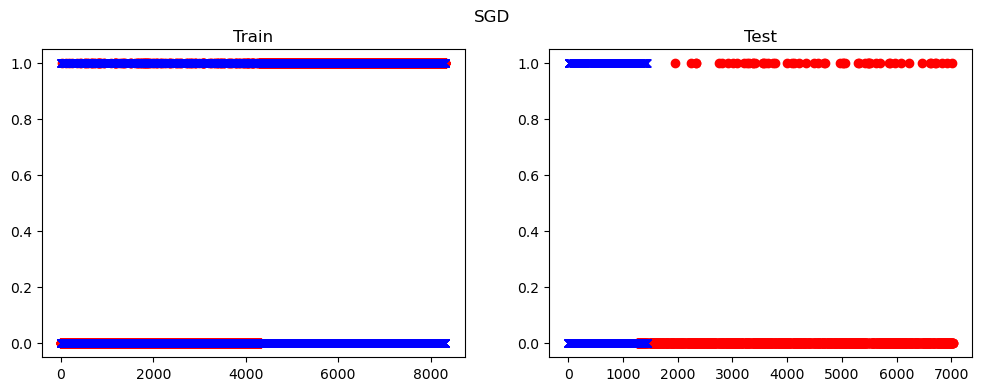

===================Logistic Reg===================


C:\Users\tarun\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy: 0.5853365384615384
Test Accuracy: 0.8454038997214485
MCC: 0.19246435836857798
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      1380
           1       0.13      0.50      0.20        56

    accuracy                           0.85      1436
   macro avg       0.55      0.68      0.56      1436
weighted avg       0.94      0.85      0.89      1436



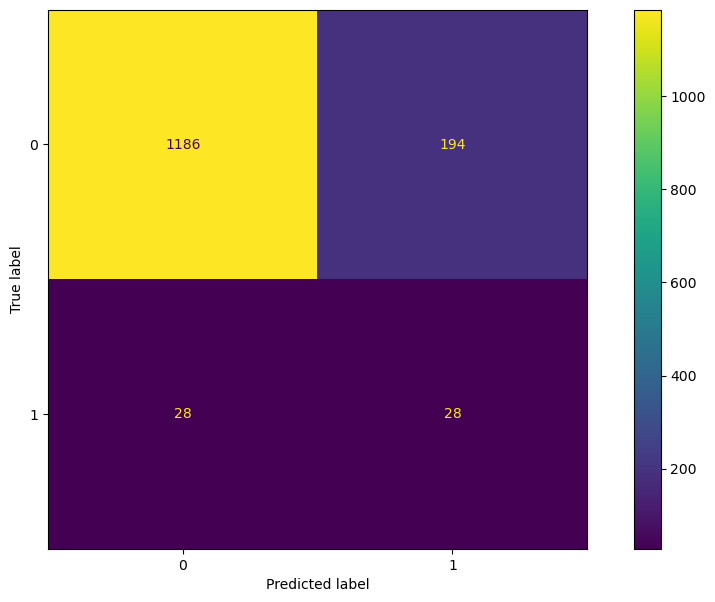

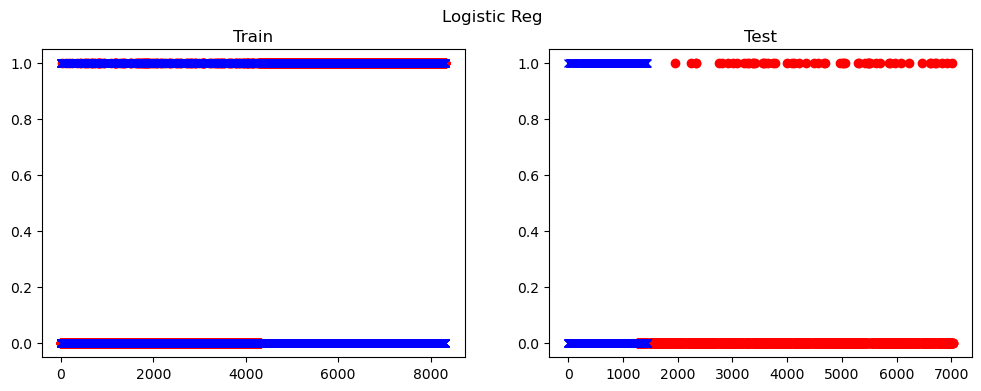

=======================kNN========================


C:\Users\tarun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\tarun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Train Accuracy: 0.8947115384615385
Test Accuracy: 0.7569637883008357


C:\Users\tarun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\tarun\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

MCC: 0.04425197385129316
              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1380
           1       0.05      0.32      0.09        56

    accuracy                           0.76      1436
   macro avg       0.51      0.55      0.48      1436
weighted avg       0.93      0.76      0.83      1436



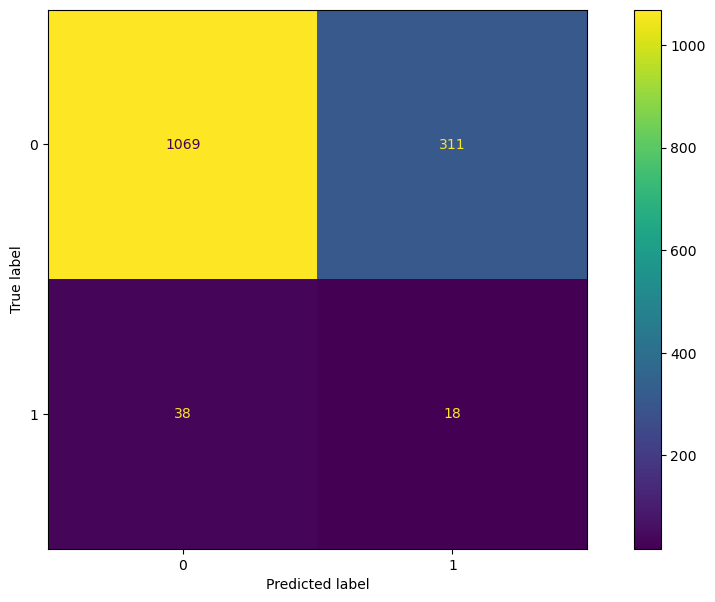

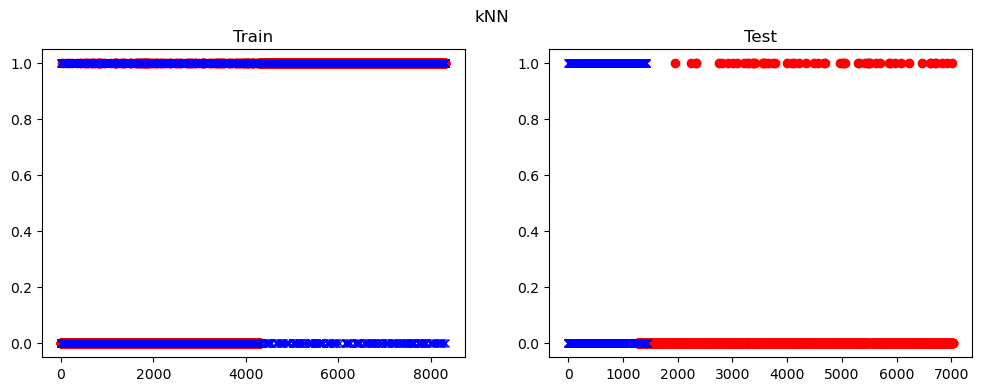

===================Naive Bayes====================
Train Accuracy: 0.5241586538461539
Test Accuracy: 0.09610027855153204
MCC: 0.006475478274224585
              precision    recall  f1-score   support

           0       0.97      0.06      0.12      1380
           1       0.04      0.95      0.08        56

    accuracy                           0.10      1436
   macro avg       0.50      0.50      0.10      1436
weighted avg       0.93      0.10      0.11      1436



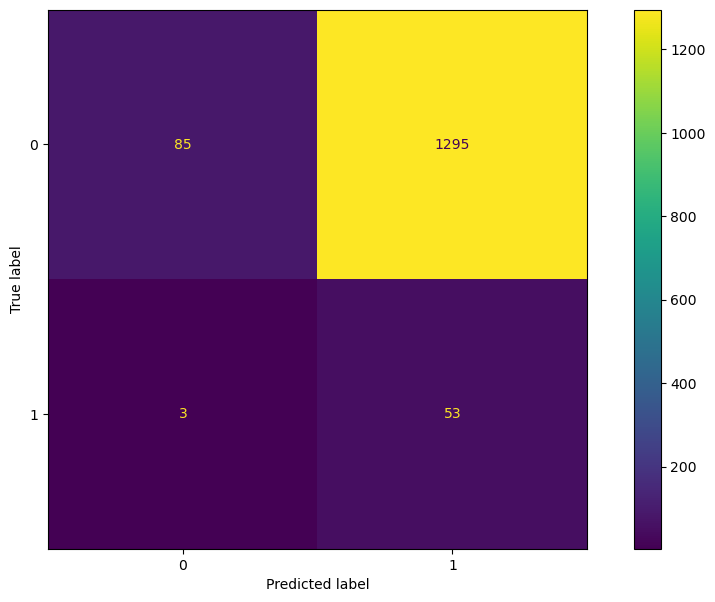

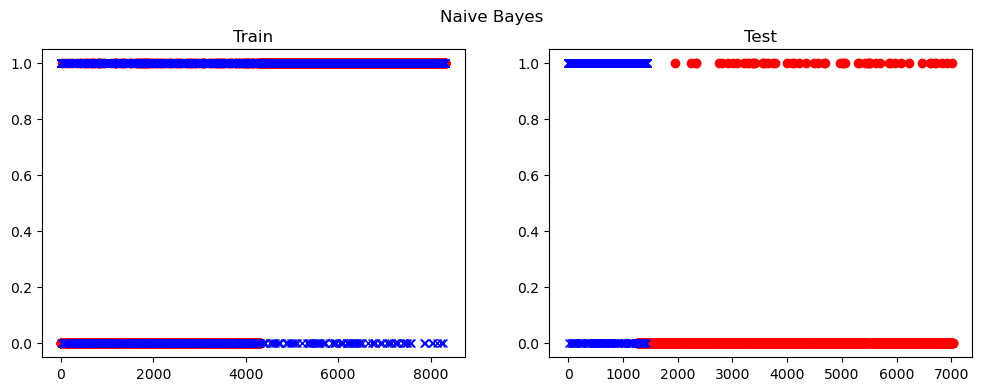

==============Support Vector Machine==============
Train Accuracy: 0.5931490384615384
Test Accuracy: 0.3286908077994429
MCC: 0.06207689412041901
              precision    recall  f1-score   support

           0       0.98      0.31      0.47      1380
           1       0.05      0.84      0.09        56

    accuracy                           0.33      1436
   macro avg       0.51      0.57      0.28      1436
weighted avg       0.94      0.33      0.45      1436



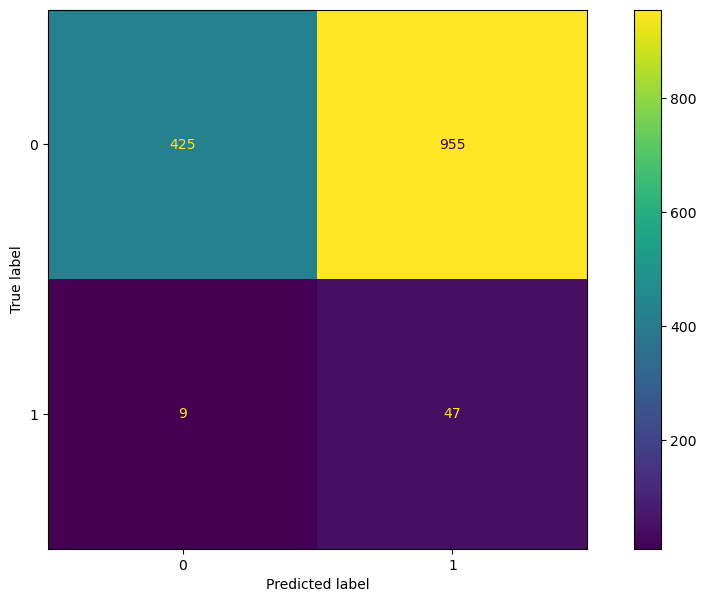

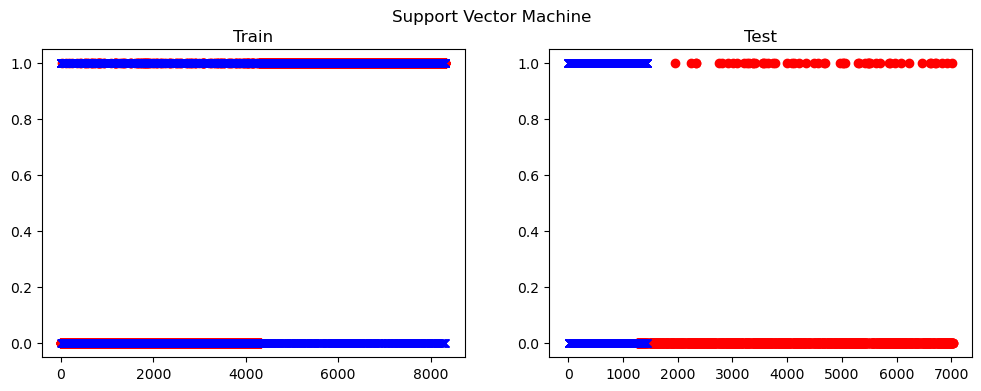

In [187]:
train_accs, test_accs = MyModel(X_train, X_test, y_train, y_test)

# Deep Learning Method

In [188]:
train_accs ,test_accs = nn_grid_search(X_train, y_train,X_test,y_test,train_accs ,test_accs, score_method='recall')
print('Finished training Neural Network...')

C:\Users\tarun\AppData\Local\Temp\ipykernel_8372\123498631.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=nn_layers)
C:\Users\tarun\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tarun\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/10
65/65 [==============================] - 11s 9ms/step - loss: 0.5403 - acc: 0.7370
Epoch 2/10
65/65 [==============================] - 0s 5ms/step - loss: 0.3598 - acc: 0.8639
Epoch 3/10
65/65 [==============================] - 0s 4ms/step - loss: 0.2497 - acc: 0.9175
Epoch 4/10
65/65 [==============================] - 0s 5ms/step - loss: 0.1901 - acc: 0.9352
Epoch 5/10
65/65 [==============================] - 0s 4ms/step - loss: 0.1552 - acc: 0.9489
Epoch 6/10
65/65 [==============================] - 0s 4ms/step - loss: 0.1330 - acc: 0.9561
Epoch 7/10
65/65 [==============================] - 0s 3ms/step - loss: 0.1147 - acc: 0.9645
Epoch 8/10
65/65 [==============================] - 0s 4ms/step - loss: 0.1037 - acc: 0.9669
Epoch 9/10
65/65 [==============================] - 0s 4ms/step - loss: 0.0969 - acc: 0.9675
Epoch 10/10
65/65 [==============================] - 0s 4ms/step - loss: 0.0882 - acc: 0.9725
Best parameters:  {'kerasclassifier__batch_size': 128, 'kerasclassif

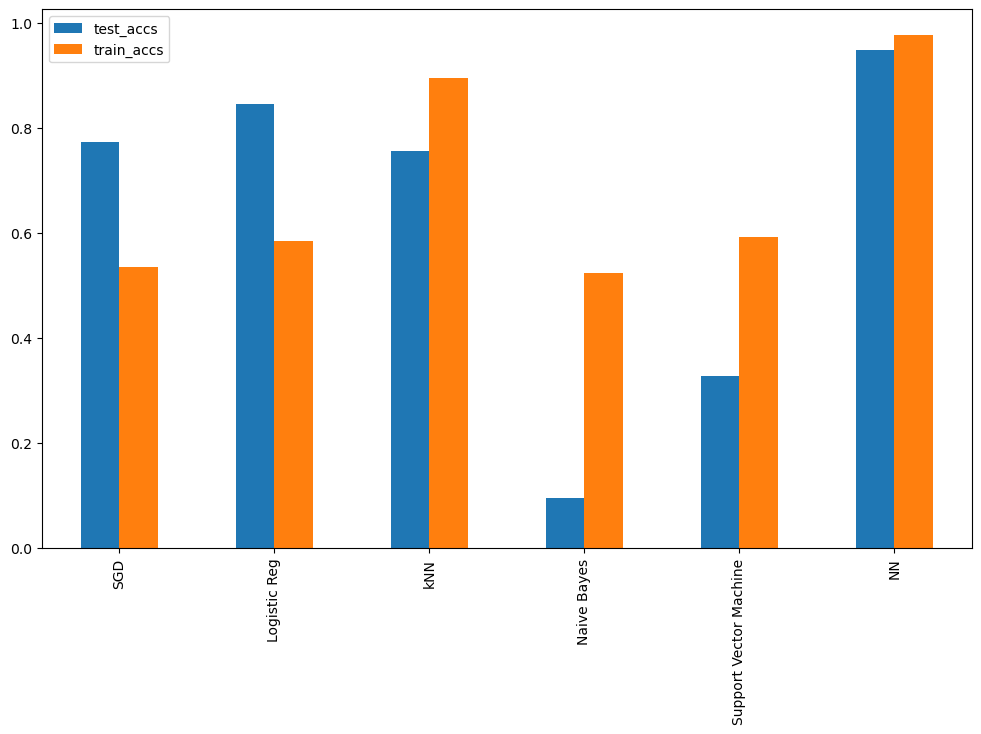

In [189]:
names = ["SGD", "Logistic Reg", "kNN", "Naive Bayes","Support Vector Machine","NN"]
_data = {'test_accs':test_accs,'train_accs':train_accs}
_df = pd.DataFrame(_data,columns=['test_accs','train_accs'],index=names)
_df.plot.bar()
plt.show()

In [190]:
!pip install fastai && pip install -Uqq torchsummary
#!pip install --force-reinstall fastai==2.5.3 && pip install -Uqq torchsummary && pip install --force-reinstall fastcore==1.3.27 && pip install --force-reinstall torch==1.8.1
from fastai.vision.all import *
from fastai.data.all import *

In [191]:
import torch 

# Set PyTorch to use CPU ONLY 
# device = torch.device("cpu")
# torch.cuda.is_available = lambda : False

# Select which device PyTorch should use. If you have a gpu but
# want to use a the cpu only comment out this line and use the above
# lines instead.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import fastai
assert fastai.__version__ >= '2.2.7'
from fastai.tabular.all import *

epoch,train_loss,valid_loss,accuracy,time
0,0.507537,0.195884,0.959059,00:01
1,0.388049,0.231863,0.959059,00:01
2,0.285907,0.220112,0.959059,00:01
3,0.224492,0.181876,0.959059,00:01
4,0.200325,0.177642,0.959059,00:01


tensor([-0.2544])
tensor([0, 0, 0,  ..., 0, 0, 0])


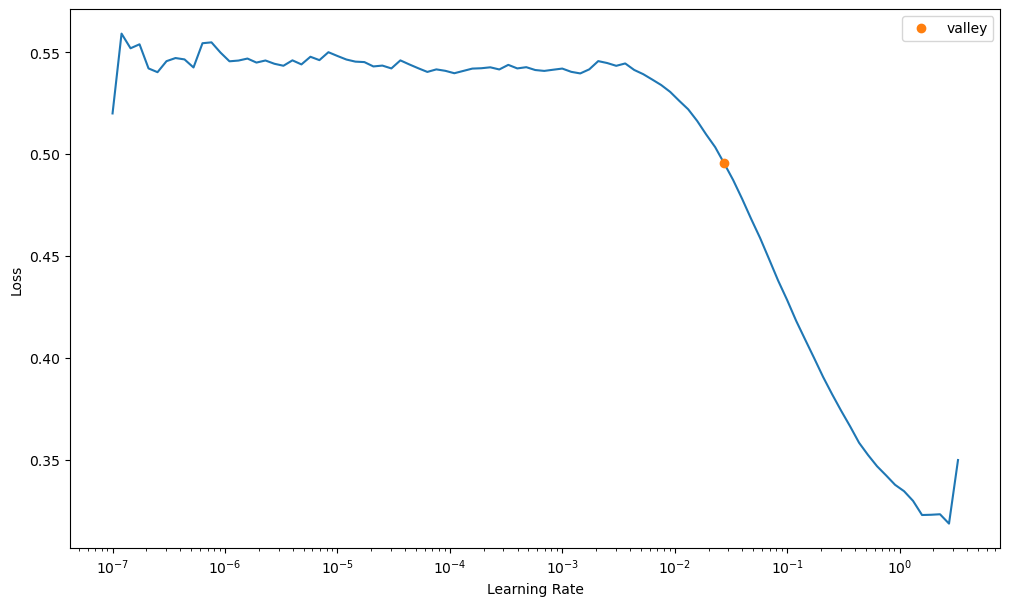

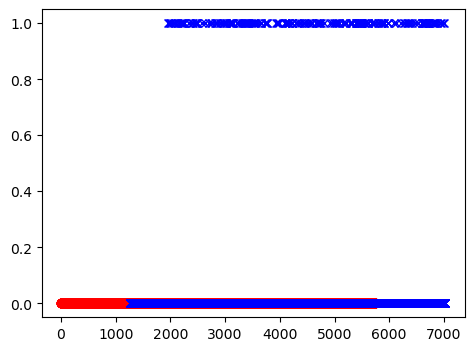

In [192]:
import torch.nn as nn
#/**hu = 16
#model = nn.Sequential(
#          nn.Flatten(),          
#          nn.Linear(in_features=64, out_features=hu),
#          nn.Dropout(p=0.25),
#          nn.ReLU(),
#          nn.Linear(in_features=hu, out_features=hu),
#          nn.Dropout(p=0.25),
#          nn.ReLU(),
#          nn.Linear(in_features=hu, out_features=1),
#          nn.LogSoftmax()
#        ).to(device)**/

#nll_loss = nn.NLLLoss()

dls = TabularDataLoaders.from_df(data, y_names="Bankrupt", device=device)
dls.one_batch()[0].shape




learn = tabular_learner(dls,metrics=accuracy,layers=[64,32,1])

# select the appropriate learning rate
learn.lr_find()

# we typically find the point where the slope is steepest
#learn.recorder.plot()

# Fit the model based on selected learning rate
learn.fit_one_cycle(5)

# Analyse our model
#learn.model
#learn.recorder.plot_losses()

#use the predict method on a row
#row, clas, probs = learn.predict(df.iloc[0])

test_df = data.copy()
test_df.drop(['Bankrupt'], axis=1, inplace=True)
testdl = learn.dls.test_dl(test_df)

#learn.fit(n_epoch=5,lr=0.01)

#learn.fit_one_cycle(1)

#learn.show_results()

#learn.recorder.plot_loss(skip_start=0)

vld_logprobs, vld_targets = learn.get_preds(dl=testdl)

#learn.get_preds(dl=testdl)

print(vld_logprobs[0])

vld_preds = vld_logprobs.argmax(axis=1)
print(vld_preds)

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(vld_preds, 'ro')
plt.plot(data.loc[:,'Bankrupt'], 'bx')

plt.show()

# Conclusion

In [ ]:
Deep Learnining Method Provides the best accuracy for predictions of Bank failure among all 6 models 
